In [2]:
%pylab inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [15, 8]
from mpl_toolkits.mplot3d import Axes3D


Populating the interactive namespace from numpy and matplotlib


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Heun's method

In [4]:
def heuns(h, f, domain):
    x0 = domain[0][0]
    y0 = domain[0][1]
    x_end = domain[1][0]
    y_end = domain[1][1]
    
    pts = [(x0,y0)]
    
    x = x0
    y = y0
    
    while x <= x_end:
        
        dxdy = f(x,y)
        dxdy_next = f(x+h, y + h*f(x,y))
        if f(x,y) is None or dxdy_next is None:
            break
        
        x_next = x + h
        y_next = y + 0.5*h*(dxdy + dxdy_next)
        
        pts.append((x_next,y_next))
        
        x = pts[-1][0]
        y = pts[-1][1]
    return pts

#### Helper functions

In [5]:
def get_sols(sol, h, steps, domain):
    x0 = domain[0][0]
    y0 = sol(x0)
    x_end = domain[1][0]
    
    pts = [(x0,y0)]
    
    x = x0
    y = y0
    
    while len(pts) <= steps:
        curr_sol = sol(x)
        if curr_sol is not None:
            pts.append((x,y))
            x = x + h
            y = curr_sol
        else:
            break
    return pts
        
def sol1(x):
    y = sin((x**2)/2) + 4
    return y

def dydx_1(x,y):
    if not (isnan(x*sqrt(1-(y-4)**2))):
        return x*sqrt(1-(y-4)**2)
    else:
        return None

def sol2(x):
    if not (isnan(0.1*sqrt(1-2*x))):
        return 1/(sqrt(1-2*x))
    else:
        return None

def dydx_2(x,y):
    return y**3

<ipython-input-5-ba6e4cb79f33>:26: RuntimeWarning: invalid value encountered in sqrt
  if not (isnan(x*sqrt(1-(y-4)**2))):


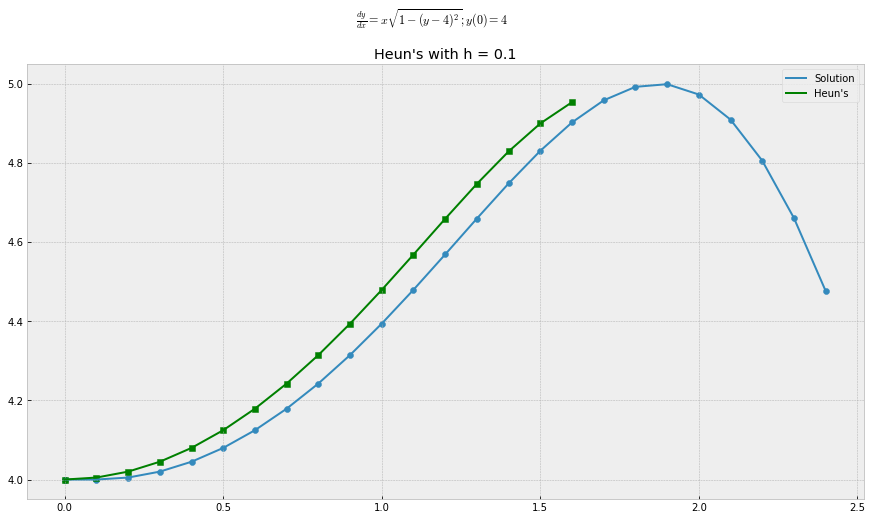

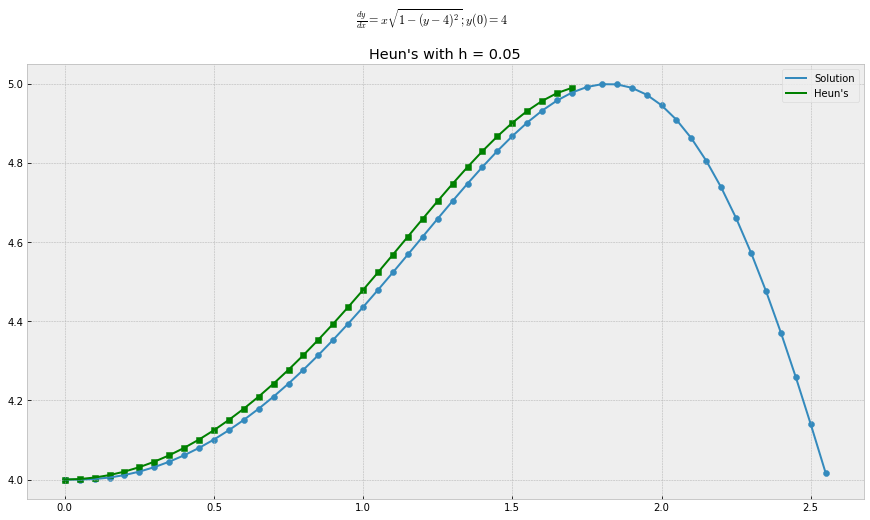

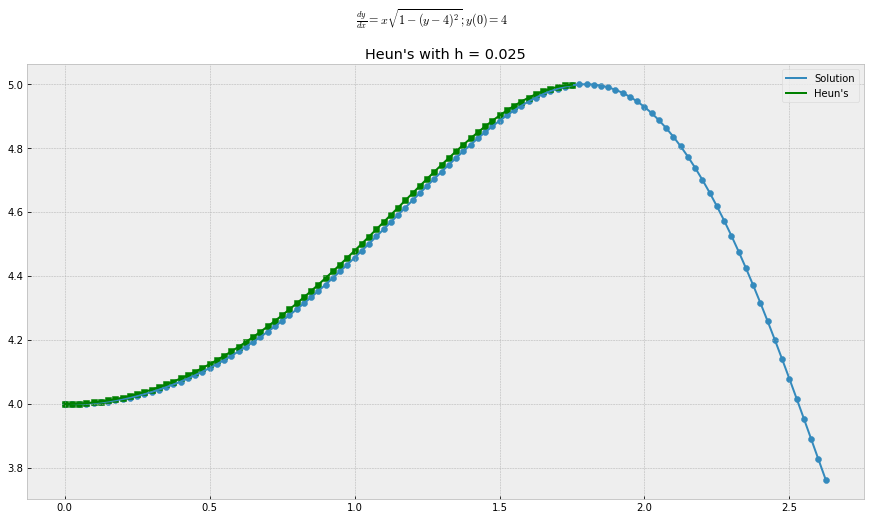

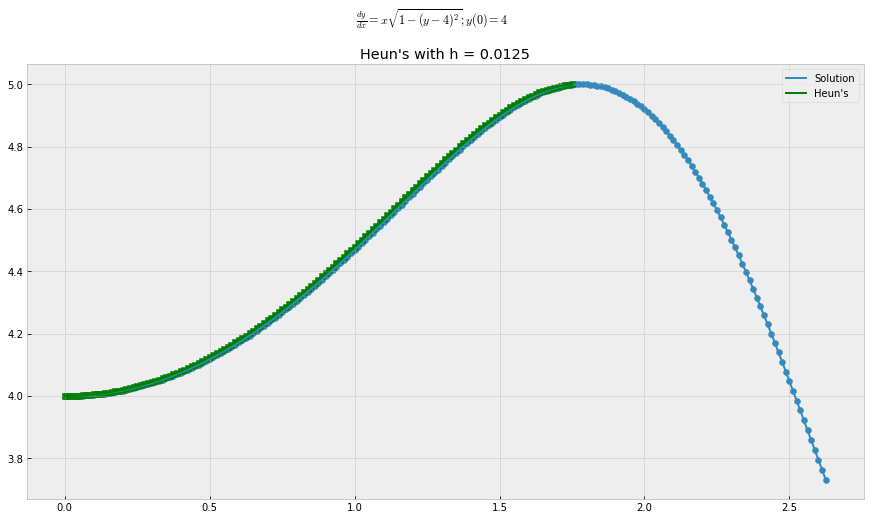

In [6]:
hs = [0.1,0.05,0.025,0.0125]

def test_a():
    for j in range(len(hs)):
        h = hs[j]
        domain = [(0,4),(100,100)]

        pts1b = heuns(h,dydx_1,domain)
        xs1b = [p[0] for p in pts1b]
        ys1b = [p[1] for p in pts1b]

        sols1 = get_sols(sol1, h, int(len(pts1b)*1.5), domain)

        sols_x1 = [p[0] for p in sols1]
        sols_y1 = [p[1] for p in sols1]

        figure(j+len(hs))
        plt.suptitle(r'$\frac{dy}{dx} = x\sqrt{1 - (y-4)^{2}} ;y(0) = 4$')
        plt.title("Heun's with h = {}".format(h))

        scatter(sols_x1,sols_y1)
        plot(sols_x1,sols_y1, label='Solution')

        scatter(xs1b,ys1b,color='green',marker='s')
        plot(xs1b,ys1b,color='green', label='Heun\'s')


        plt.legend()
        #plt.grid()
test_a()

## Dynamic Heun's Method

In [7]:
def dynamic_heuns(h, sys_vars, fs, domain):
    """
    Heun's method of approximating a dynamical system.
    @param: h: time step for t (or delta_t).
    @param: sys_vars: a list of lists of values for the variables for the system, e.g. [[x(t)s],[y(t)s],[z(t)s]].
    @param: domain: list of tuples (or lists) of starting and ending values for the variables, e.g. [(x0,y0,z0),(xn,yn,zn)].
    """
    running = True
    
    pts = [domain[0]]
    ends = domain[1]
    curr_vars = domain[0]
    
    while running:
        for j in range(len(ends)):
            if curr_vars[j] > ends[j]:
                running = False
                break
                
        new_vars = []
        for i in range(len(fs)-1):
            f = fs[i]
            curr_f = f(curr_vars)
            
            if curr_f is None:
                print("break early 1")
                running = False
                break
            
            next_vars = curr_vars[:]
            next_vars[-1] = next_vars[-1] + h
            next_vars[i] = curr_vars[i] + h*curr_f
            next_f = f(next_vars)
            
            if curr_f is None or next_f is None:
                print("break early 2")
                running = False
                break
            else:
                var = curr_vars[i] + 0.5*h*(curr_f + next_f)
                sys_vars[i].append(var)
                new_vars.append(var)
                
        # Increment t
        sys_vars[-1].append(curr_vars[-1] + h)
        new_vars.append(curr_vars[-1] + h)
        
        if curr_f is None or next_f is None:
                break
        
        pts.append(new_vars)
        
        curr_vars = new_vars
        
    return pts

### Setting up the test model

In [10]:
sig = 10
bet = 8/3
rho = 28

#h = 0.05
h = 0.01

inits = [1,1,1,0]
#ends = [100,100,100,100]
ends = [100,100,100,100]

def fx(curr_vars):
    curr_x = curr_vars[0]
    curr_y = curr_vars[1]
    curr_z = curr_vars[2]
    curr_t = curr_vars[3]
    return sig*(curr_y-curr_x)

def fy(curr_vars):
    curr_x = curr_vars[0]
    curr_y = curr_vars[1]
    curr_z = curr_vars[2]
    curr_t = curr_vars[3]
    return (curr_x*(rho - curr_z) - curr_y)

def fz(curr_vars):
    curr_x = curr_vars[0]
    curr_y = curr_vars[1]
    curr_z = curr_vars[2]
    curr_t = curr_vars[3]
    return (curr_x*curr_y) - (bet*curr_z)

def ft(curr_vars):
    curr_x = curr_vars[0]
    curr_y = curr_vars[1]
    curr_z = curr_vars[2]
    curr_t = curr_vars[3]
    return 1


### Plotting the model

Original dynamical system of differential equations:
\begin{cases}
\frac{\text{d}x}{\text{d}t} = \sigma(y-x)\\
\frac{\text{d}y}{\text{d}t} = x(\rho-z)-y\\
\frac{\text{d}z}{\text{d}t} = xy - \beta z
\end{cases}

Euler's approximation:
\begin{cases}
x_{i+1} = x_{i} + h\cdot\sigma(y_{i}-x_{i})\\
y_{i+1} = y_{i}+h\cdot[x_{i}(\rho-z_{i})-y_{i}]\\
z_{i+1} = z_{i} + h\cdot(x_{i}y_{i} - \beta z_{i})\\
t_{i+1} = t_{i} + h
\end{cases}

In [11]:
def lorenz_heuns():
    pts = dynamic_heuns(h, [[],[],[],[]], [fx,fy,fz,ft],[inits,ends])
    print(len(pts))
    xs1 = [p[0] for p in pts]
    ys1 = [p[1] for p in pts]
    zs1 = [p[2] for p in pts]
    ts1 = [p[3] for p in pts]

    fig = figure(2)
    lorenz = fig.gca(projection='3d')
    plt.title("Heun's approximation of Lorenz System")
    plot(xs1,ys1,zs1, lw='1', color='lightcoral')

10002


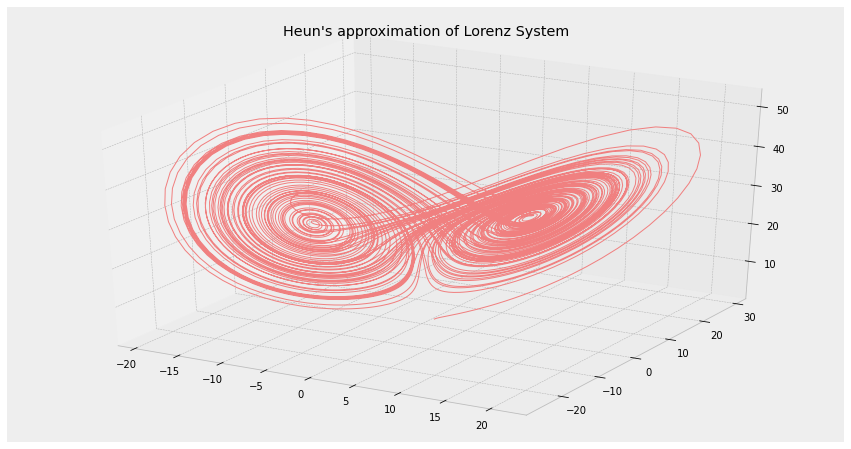

In [12]:
lorenz_heuns()